In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [13]:
ticker = 'HD'
start_date = '2010-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
print(data.head(10))


[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open    Volume
Ticker             HD         HD         HD         HD         HD        HD
Date                                                                       
2010-01-04  19.933252  28.670000  29.150000  28.549999  29.150000  13120900
2010-01-05  20.079250  28.879999  28.990000  28.290001  28.730000  15594300
2010-01-06  20.009727  28.780001  29.000000  28.700001  28.879999   8833200
2010-01-07  20.246119  29.120001  29.219999  28.730000  28.860001  12058200
2010-01-08  20.148785  28.980000  29.240000  28.690001  29.000000  15609800
2010-01-11  19.578659  28.160000  29.020000  28.080000  29.000000  23670500
2010-01-12  19.453506  27.980000  28.350000  27.889999  28.150000  23075800
2010-01-13  19.557796  28.129999  28.250000  28.000000  28.000000  15639100
2010-01-14  19.675997  28.299999  28.440001  28.120001  28.120001  13208200
2010-01-15  19.863726  28.570000  28.690001  28.000000  28.309999  23013500


In [ ]:
# 计算 log-return
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
log_returns = data['LogReturn'].dropna()

# N 是有效 log-return 的数量
N = len(log_returns)

# 估计 μ（公式 9）：日均 drift
mu_hat = log_returns.mean()

# 估计 σ²（公式 14）：日方差（样本方差，已扣除 drift）
sigma2_hat = ((log_returns - mu_hat)**2).sum() / (N - 1)

# 输出结果（不年化）
print(f"N = {N} 个交易日")
print(f"μ_hat (mean of log-return) ≈ {mu_hat:.6f} per day")
print(f"σ²_hat (variance of log-return) ≈ {sigma2_hat:.6f} per day²")
print(f"σ_hat (volatility) ≈ {np.sqrt(sigma2_hat):.6f} per day")

# 年化转换系数
trading_days = 252

# 年化 drift
mu_annual = mu_hat * trading_days

# 年化方差和波动率
sigma2_annual = sigma2_hat * trading_days
sigma_annual = np.sqrt(sigma2_annual)

# 输出年化结果
print(f"μ_hat ≈ {mu_annual:.6f} per year (annualized drift)")
print(f"σ²_hat ≈ {sigma2_annual:.6f} per year² (annualized variance)")
print(f"σ_hat ≈ {sigma_annual:.6f} per year (annualized volatility)")


N = 3840 个交易日
μ_hat (mean of log-return) ≈ 0.000656 per day
σ²_hat (variance of log-return) ≈ 0.000219 per day²
σ_hat (volatility) ≈ 0.014786 per day
μ_hat ≈ 0.165202 per year (annualized drift)
σ²_hat ≈ 0.055092 per year² (annualized variance)
σ_hat ≈ 0.234717 per year (annualized volatility)


[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open    Volume
Ticker             HD         HD         HD         HD         HD        HD
Date                                                                       
2010-01-04  19.933252  28.670000  29.150000  28.549999  29.150000  13120900
2010-01-05  20.079250  28.879999  28.990000  28.290001  28.730000  15594300
2010-01-06  20.009727  28.780001  29.000000  28.700001  28.879999   8833200
2010-01-07  20.246119  29.120001  29.219999  28.730000  28.860001  12058200
2010-01-08  20.148785  28.980000  29.240000  28.690001  29.000000  15609800
2010-01-11  19.578659  28.160000  29.020000  28.080000  29.000000  23670500
2010-01-12  19.453506  27.980000  28.350000  27.889999  28.150000  23075800
2010-01-13  19.557796  28.129999  28.250000  28.000000  28.000000  15639100
2010-01-14  19.675997  28.299999  28.440001  28.120001  28.120001  13208200
2010-01-15  19.863726  28.570000  28.690001  28.000000  28.309999  23013500
2010-01-19  

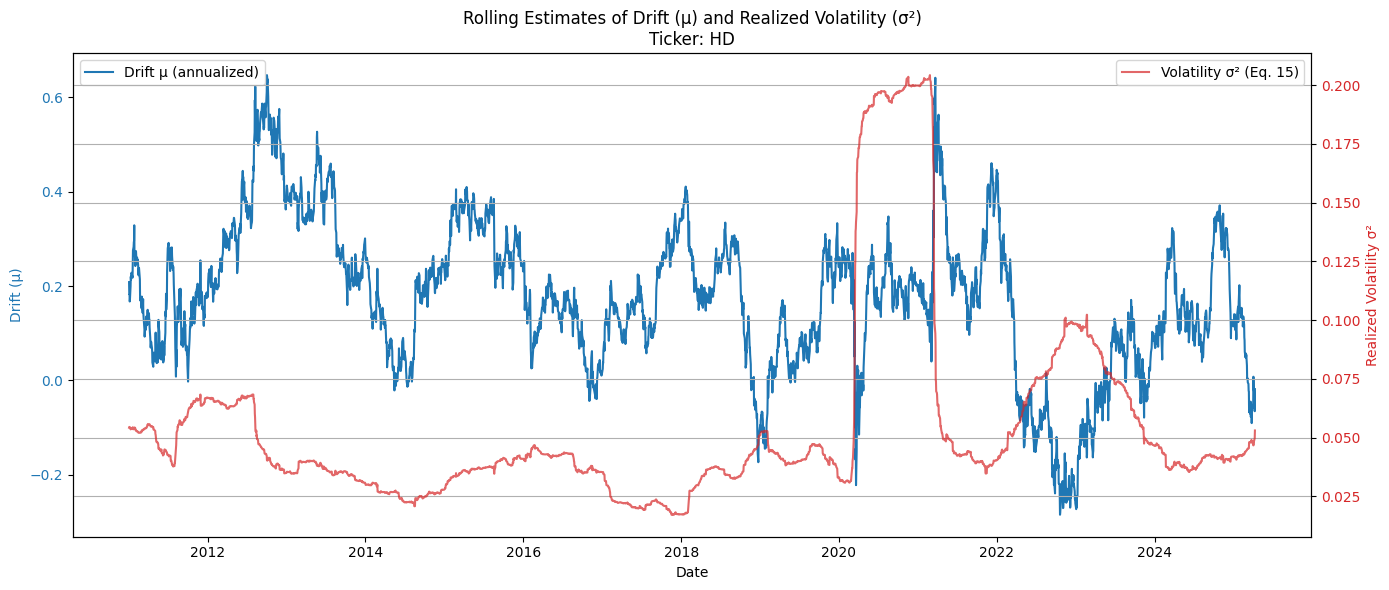

In [ ]:
def sigma2_from_eq15(log_returns, N = 252, delta_t=1/252):
    """
    基于公式 (15) 估计年化 realized volatility
    参数:
        log_returns: 一段 log return 时间序列（pd.Series）
        delta_t: 时间步长，默认为日频 (1/252)
    返回:
        sigma2_hat: 实现波动率的无偏估计 σ²（年化）
    """
    if log_returns.isnull().any():
        return np.nan

    T = N * delta_t

    # μ̂_N 的估计
    mu_hat = log_returns.mean() / delta_t

    # 第一个求和项：Σ r_k^2
    sum_squared_returns = (log_returns ** 2).sum()

    # 最终波动率估计
    sigma2_hat = (1 / ((N - 1) * delta_t)) * sum_squared_returns - (T / (N - 1)) * mu_hat**2
    return sigma2_hat

N = 252 # Number of trading days in a year
delta_t = 1 / N # Time increment in years

data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
log_returns = data['LogReturn'].dropna().iloc[-N:]

data['RollingMu'] = data['LogReturn'].rolling(window=N).mean() / delta_t  # see equation (10) in the appendix
data['Sigma2_rolling'] = data['LogReturn'].rolling(window=N).apply(sigma2_from_eq15, args=(N, delta_t), raw=False)
data['Sigma_rolling'] = np.sqrt(data['Sigma2_rolling'])


# 开始绘图
fig, ax1 = plt.subplots(figsize=(14, 6))

# 第一条 Y 轴：画 μ (drift)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Drift (μ)', color=color)
ax1.plot(data.index, data['RollingMu'], color=color, label='Drift μ (annualized)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# 第二条 Y 轴：画 σ² (volatility)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Realized Volatility σ²', color=color)
ax2.plot(data.index, data['Sigma2_rolling'], color=color, label='Volatility σ² (Eq. 15)', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# 美化标题和布局
plt.title(f"Rolling Estimates of Drift (μ) and Realized Volatility (σ²)\nTicker: {ticker}")
fig.tight_layout()
plt.grid(True)
plt.show()

